In [3]:
%pwd

'/home/zhouyi/frequency/happy_zhou'

In [2]:
import sys

import itertools

import torch
import torch.optim as optim
from allennlp.data.dataset_readers.seq2seq import Seq2SeqDatasetReader
from allennlp.data.iterators import BucketIterator
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data.tokenizers.character_tokenizer import CharacterTokenizer
from allennlp.data.tokenizers.word_tokenizer import WordTokenizer
from allennlp.data.vocabulary import Vocabulary
from allennlp.nn.activations import Activation
from allennlp.models.encoder_decoders.simple_seq2seq import SimpleSeq2Seq
from allennlp.modules.attention import LinearAttention, BilinearAttention, DotProductAttention
from allennlp.modules.seq2seq_encoders import PytorchSeq2SeqWrapper, StackedSelfAttentionEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.predictors import Seq2SeqPredictor
from allennlp.training.trainer import Trainer
from allennlp.data.dataset_readers.stanford_sentiment_tree_bank import StanfordSentimentTreeBankDatasetReader
import hashlib
from luna import auto_create, load_var, log, log_config
import pathlib
from allennlp.modules.token_embedders import Embedding, TokenEmbedder
from allennlp.modules.token_embedders.embedding import \
    _read_pretrained_embeddings_file
from awesome_sst.sst_model import LstmClassifier
from allennlpx import allenutil
from allennlpx.predictors.text_classifier import TextClassifierPredictor
from allennlp.modules.seq2seq_decoders import AutoRegressiveSeqDecoder, LstmCellDecoderNet
from allennlp.modules.seq2seq_encoders import StackedBidirectionalLstm
from allennlp.models import ComposedSeq2Seq
from luna import load_model
from luna import chunks

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from allennlp.data.token_indexers.wordpiece_indexer import PretrainedBertIndexer


In [3]:
token_indexer = PretrainedBertIndexer(pretrained_model='bert-base-uncased', do_lowercase=True)
# token_indexer = SingleIdTokenIndexer(lowercase_tokens=True)

sub_reader = StanfordSentimentTreeBankDatasetReader(token_indexers={"tokens": token_indexer},
                                                    granularity='2-class',
                                                    use_subtrees=True)
reader = StanfordSentimentTreeBankDatasetReader(token_indexers={"tokens": token_indexer},
                                                granularity='2-class')


def load_data():
    sub_train_data = sub_reader.read(
        'https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/train.txt')
    train_data = reader.read('https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/train.txt')
    dev_data = reader.read('https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/dev.txt')
    test_data = reader.read('https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/test.txt')
    return sub_train_data, train_data, dev_data, test_data

pretrain = "bert"
sub_train_data, train_data, dev_data, test_data = auto_create(f"{pretrain}_data", load_data, True)

vocab=load_var(f"{pretrain}_vocab")
sst_clf = LstmClassifier(vocab, pretrain=pretrain, fix_embed=False)
load_model(sst_clf, f"{pretrain}_model_feat")
sst_clf.cuda()
sst_clf.eval()

sst_predictor = TextClassifierPredictor(sst_clf, reader)


cache for bert_data exists
*** load bert_data from cache cost 3.05 seconds
Restore model from checkpoint saved/models/bert_model_feat@0.ckpt.


In [4]:
tgt_module = "word_embedders.token_embedder_tokens.bert_model.pooler.activation"
with torch.no_grad():
    sent_embeds = []
    with sst_predictor.capture_named_internals(tgt_module) as internals:
        outputs = sst_predictor.predict_batch_instance(test_data[:500])
        sent_embed = internals[tgt_module]
#         internals
#     for k in internals.keys():
#         if pretrain == 'bert' and 'Tanh()' in internals[k]['name']:
#             sent_embeds.append(internals[k]['output'])
#         if pretrain != 'bert' and "PytorchSeq2VecWrapper" in internals[k]['name']:
#             sent_embeds.append(internals[k]['output'])

Encountered the loss key in the model's return dictionary which couldn't be split by the batch size. Key will be ignored.


tensor([670, 655, 304, 609, 376,  94, 456, 249, 698, 139], device='cuda:0')

In [5]:
sent_embeds = None
outputs = None
internals = None
torch.cuda.empty_cache()

In [6]:
if pretrain == 'bert':
    tgt_module = "word_embedders.token_embedder_tokens.bert_model.pooler.activation"

with torch.no_grad():
    sent_embeds = []
    sent_preds = []
    sent_labels = []
    for instances in chunks(test_data, 100):
        with sst_predictor.capture_named_internals(tgt_module) as internals:
            outputs = sst_predictor.predict_batch_instance(instances)
            sent_embeds.append(internals[tgt_module])
        
        for i, ele in enumerate(outputs):
            sent_preds.append(ele['probs'][vocab.get_token_index('1', 'labels')] > ele['probs'][vocab.get_token_index('0', 'labels')])
        for instance in instances:
            sent_labels.append(instance.fields['label'].label == '1')
    sent_embeds = torch.cat(sent_embeds, dim=0)
torch.cuda.empty_cache()

In [7]:
@torch.no_grad()
def inc_repr(sent='hello world'):
    sent = sent.split(" ")
    inc_sents = []
    for ti in range(1, len(sent) + 1):
        inc_sents.append({"sentence": allenutil.as_sentence(sent[:ti])})
#     print(inc_sents)
    sent_embeds = []
    sent_preds = []
    with sst_predictor.capture_named_internals(tgt_module) as internals:
        outputs = sst_predictor.predict_batch_json(inc_sents)
        sent_embeds.append(internals[tgt_module])
    for i, ele in enumerate(outputs):
        sent_preds.append(ele['probs'][vocab.get_token_index('1', 'labels')] > ele['probs'][vocab.get_token_index('0', 'labels')])
#     print(sent_embeds[1].size())
    sent_embeds = torch.cat(sent_embeds, dim=0)
    return sent_embeds, sent_preds

In [36]:
# allenutil.as_sentence(instance)
mysents = [
    "The dog is lovely , it is not scary .",
    "The dog is not lovely , it is scary.",
    "The dog is scary , it is not lovely .",
    "The dog is not scary , it is lovely .",
#     "I like you .",
#     "I do not like you .",
#     "I hate you .",
#     "I do not hate you .",    
]
myembeds = []
mypreds = []
for sent in mysents:
    pp = ""
    for i, ele in enumerate(sent.split(" ")):
        pp += f"{ele}'{i} "
    print(pp)
    embed, pred = inc_repr(sent)
    myembeds.append(embed)
    mypreds.append(pred)

    
_, idxs = torch.topk(sst_clf.linear.weight.abs().sum(0), k = 25)
# _, idxs = torch.topk(sst_clf.linear.weight[0].abs(), k = 3)
idxs

allembeds = [sent_embeds.index_select(1, idxs).cpu().numpy(), 
             *[ele.index_select(1, idxs).cpu().numpy() for ele in myembeds]]
allsizes = [ele.shape[0] for ele in allembeds]
all2ds = TSNE(n_components=2).fit_transform(np.concatenate(allembeds))


The'0 dog'1 is'2 lovely'3 ,'4 it'5 is'6 not'7 scary'8 .'9 
The'0 dog'1 is'2 not'3 lovely'4 ,'5 it'6 is'7 scary.'8 
The'0 dog'1 is'2 scary'3 ,'4 it'5 is'6 not'7 lovely'8 .'9 
The'0 dog'1 is'2 not'3 scary'4 ,'5 it'6 is'7 lovely'8 .'9 


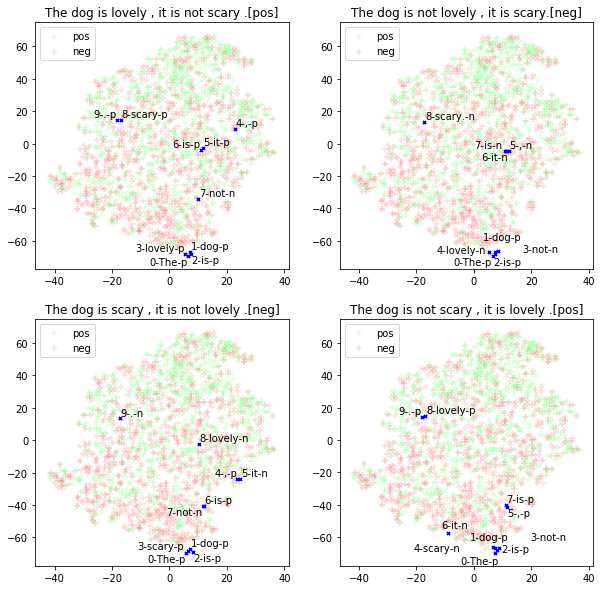

In [37]:
from adjustText import adjust_text

mask = sent_preds
plt.rcParams['figure.figsize'] = [10, 10]
for mynum in range(1, len(mysents) + 1):
    plt.subplot(2, 2, mynum)

    cur_sent = mysents[mynum - 1]
    cur_words = cur_sent.split(" ")
    cur_pred = mypreds[mynum - 1]
    
    plt.scatter(all2ds[:allsizes[0]][:, 0][np.array(mask)], all2ds[:allsizes[0]][:, 1][np.array(mask)], c='#00FF0020', label='pos', marker='+')
    plt.scatter(all2ds[:allsizes[0]][:, 0][~np.array(mask)], all2ds[:allsizes[0]][:, 1][~np.array(mask)], c='#FF000020', label='neg', marker='+')
    plt.title(cur_sent + ("[pos]" if cur_pred[-1] else '[neg]'))
    
    start_idx = sum(allsizes[:mynum])
    end_idx = sum(allsizes[:mynum+1])
    fooembed = all2ds[start_idx: end_idx]
    plt.scatter(fooembed[:, 0], fooembed[:, 1], c='b', marker='x', s=10)
    texts = [plt.text(fooembed[i, 0], fooembed[i, 1], "{}-{}-{}".format(i, cur_words[i], "p" if cur_pred[i] else 'n'), ha='center', va='center') for i in range(fooembed.shape[0])]
    adjust_text(texts)
    
    plt.legend()



In [155]:
# vocab._retained_counter['tokens']['not']
v = Vocabulary.from_instances(train_data)
print(len(train_data))
print(v._retained_counter['tokens']['not'])


100%|██████████| 6920/6920 [00:00<00:00, 32921.84it/s]

6920
439
